In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.autograd import Variable

In [2]:
def deconv(input_channels, output_channels, kernel_size=5, stride=2, padding=2, output_padding=1): #stride=(1,2,2,1) -> stride=2, added padding=1
    return nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding)

In [3]:
print("haha")

haha


In [4]:
#test
input = torch.randn(1, 16, 8, 8)
downsample = nn.Conv2d(16, 8, 3, stride=2, padding=1)
upsample = nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1)
h = downsample(input)
print(h.size())
    
output = upsample(h, output_size=input.size())
print(output.size())
output = nn.ConvTranspose2d(16, 16, 5, stride=2, padding=2,output_padding=1)(output, [1,16,16,16])
print(output.size())
output = nn.ConvTranspose2d(16, 16, 5, stride=2, padding=2)(output, [1,16,32,32])
print(output.size())



torch.Size([1, 8, 4, 4])
torch.Size([1, 16, 8, 8])
torch.Size([1, 16, 16, 16])
torch.Size([1, 16, 32, 32])


In [21]:
def conv(input_channels, output_channels, kernel_size=5, stride=2, padding=2): #stride=(1,2,2,1) -> stride=2
    return nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding)

In [6]:
class Generator(nn.Module):
    '''
	Inputs:
	z_dim : Noise dimension 100
	t_dim : Text feature dimension 256
	image_size : Image Dimension 64
    gf_dim: no of conv in first layer of generator
    df_dim: no of conv in first layer of discriminator
	caption_vector_length : Caption Vector Length 2400
	batch_size : Batch Size 64
	'''
    def __init__(self, z_dim=100, t_dim=256, image_size=128, gf_dim=64, batch_size=64, caption_vector_size=2400, lr=0.0002, beta1=0.5, beta2=0.999, eps=1e-08):
                                # t_dim = 256 -> 100? (according to paper)
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.text_dim = t_dim
        self.image_size = image_size
        self.batch_size = batch_size
        self.gf_dim = gf_dim
        self.caption_vector_size = caption_vector_size
        
        s = self.image_size
        s2, s4, s8, s16 = s//2, s//4, s//8, s//16
        self.s16 = s16 #added later, because forward() cannot access s16
        
        self.linear1 = nn.Linear(self.caption_vector_size, self.text_dim)
        self.lrelu = nn.LeakyReLU()
        self.linear2 = nn.Linear(self.z_dim+self.text_dim, self.gf_dim*8*s16*s16) #t_dim->text_dim
        self.relu0 = nn.ReLU()
        
        self.deconv1 = deconv(self.gf_dim*8, self.gf_dim*4, output_padding=1) #removed stride and kernel_size, using predefined stride
        self.bn1 = nn.BatchNorm2d(self.gf_dim*4) #issue..
        self.relu1 = nn.ReLU()
        
        self.deconv2 = deconv(self.gf_dim*4, self.gf_dim*2)
        self.bn2 = nn.BatchNorm2d(self.gf_dim*2)
        self.relu2 = nn.ReLU()
        
        self.deconv3 = deconv(self.gf_dim*2, self.gf_dim*1)
        self.bn3 = nn.BatchNorm2d(self.gf_dim*1) #bn1 -> bn3
        self.relu3 = nn.ReLU()
        
        self.deconv4 = deconv(self.gf_dim*1, 3)
        self.tanh = nn.Tanh()
        #self.relu = nn.Relu(inplace=True)
        #self.sigmoid = nn.Sigmoid()
        self.optimizer = optim.Adam(self.parameters(), lr=lr, betas=(beta1, beta2), eps=eps) #adam->Adam #self.block.parameters()->self.parameters()
        
    
    def forward(self, z_image, emb_caption):
        reduced_text_emb = self.lrelu(self.linear1(emb_caption))
        z_concat = torch.cat((z_image, reduced_text_emb), dim=-1)
        #print(z_concat.shape)
        z = self.linear2(z_concat)
        #print(z.shape)
        x = torch.reshape(z, (self.batch_size, self.gf_dim*8, self.s16, self.s16))
        #x = torch.reshape(z, (self.gf_dim*8, self.s16, self.s16))
        #print(x.shape)
        x = self.relu0(x)
        
        x = self.deconv1(x)
        #x = self.deconv1(x, output_size=[x.shape[0],x.shape[1]//2,x.shape[2]*2,x.shape[3]*2])
        #print(x.shape)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.deconv2(x)
        #print(x.shape)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.deconv3(x)
        #print(x.shape)
        
        x = self.bn3(x)
        x = self.relu3(x)
        
        x = self.deconv4(x)
        #print(x.shape)
        x = (self.tanh(x)/2.0 + 0.5)
        return x
        
    
        

In [34]:
class Discriminator(nn.Module):
    '''
	Inputs:
	z_dim : Noise dimension 100
	t_dim : Text feature dimension 256
	image_size : Image Dimension 64
    gf_dim: no of conv in first layer of generator
    df_dim: no of conv in first layer of discriminator
	caption_vector_length : Caption Vector Length 2400
	batch_size : Batch Size 64
	'''
    def __init__(self, z_dim=100, t_dim=256, image_size=128, df_dim=64, n_classes=1, batch_size=64, caption_vector_size=2400, lr=0.0002, beta1=0.5, beta2=0.999, eps=1e-08):
        super(Discriminator, self).__init__()
        self.z_dim = z_dim
        self.text_dim = t_dim
        self.image_size = image_size #param not included
        self.batch_size = batch_size
        self.df_dim = df_dim
        self.caption_vector_size = caption_vector_size
        self.n_classes = n_classes
        self.conv1 = conv(3, self.df_dim)
        self.lrelu1 = nn.LeakyReLU()
        
        self.conv2 = conv(self.df_dim, self.df_dim*2)
        self.bn1 = nn.BatchNorm2d(self.df_dim*2)
        self.lrelu2 = nn.LeakyReLU()
        
        self.conv3 = conv(self.df_dim*2, self.df_dim*4)
        self.bn2 = nn.BatchNorm2d(self.df_dim*4)
        self.lrelu3 = nn.LeakyReLU()
        
        self.conv4 = conv(self.df_dim*4, self.df_dim*8) # -> 512? paper says 384
        self.bn3 = nn.BatchNorm2d(self.df_dim*8)
        self.lrelu4 = nn.LeakyReLU()
        
        self.linear1 = nn.Linear(self.caption_vector_size, self.text_dim)
        
        #conv5
        self.conv5 = conv(self.df_dim*8+self.text_dim, self.df_dim*8, kernel_size=1, stride=1, padding=0)  # -> 512? paper says 384
        self.bn4 = nn.BatchNorm2d(self.df_dim*8)
        self.lrelu5 = nn.LeakyReLU()
        
        #next two layers are hardcoded
        temp_slice_area = (self.image_size//(16))**2
        self.linear_h4 = nn.Linear(self.df_dim*8*temp_slice_area, 1) #linear_h4, multiplied by 64 because per slice is 8 x 8 
        self.linear_h4_aux = nn.Linear(self.df_dim*8*temp_slice_area, self.n_classes) #linear_h4_aux, multiplied by 64 because per slice is 8 x 8
        
        
        self.sigmoid1 = nn.Sigmoid()
        self.sigmoid2 = nn.Sigmoid()
        #a tensor layer's shape in list  
        #if ar is a layer, then list(ar.shape) is the list of ar's shape values
        
        #tf.expand(input_, axis) equivalent to torch.unsqueeze(input_, axis)
        
        #self.relu = nn.Relu(inplace=True)
        #self.sigmoid = nn.Sigmoid()
        self.optimizer = optim.Adam(self.parameters(), lr=lr, betas=(beta1, beta2), eps=eps) #adam->Adam #self.block.parameters()->self.parameters()
        
    
    def forward(self, z_image, emb_caption):
        x = self.conv1(z_image)
        #print(x.shape)
        x = self.lrelu1(x)
        
        x = self.conv2(x)
        #print(x.shape)
        x = self.bn1(x)
        x = self.lrelu2(x)
        
        x = self.conv3(x)
        #print(x.shape)
        x = self.bn2(x)
        x = self.lrelu3(x)
        
        x = self.conv4(x)
        #print(x.shape) # -> 512? paper says 384
        x = self.bn3(x)
        h3 = self.lrelu4(x)
        
        h3_shape = list(h3.shape)
        reduced_text = self.lrelu5(self.linear1(emb_caption))
        #print(reduced_text.shape)
        reduced_text = torch.unsqueeze(reduced_text, 2)
        #print(reduced_text.shape)
        reduced_text = torch.unsqueeze(reduced_text, 3)
        #print(reduced_text.shape)
        tiled_emb = reduced_text.repeat(1, 1, h3_shape[2], h3_shape[2]) #x->reduced_text
        #print(tiled_emb.shape)
        
        h3_concat = torch.cat((h3, tiled_emb), 1)
        #print(h3_concat.shape)
        
        #h3_new = conv(h3_concat.shape[1], self.df_dim*8, kernel_size=1, stride=1) #another conv layer
        h3_new = self.conv5(h3_concat)
        #print(h3_new.shape)
        h3_new = self.lrelu5(self.bn4(h3_new))
        #print(h3_new.shape)
        h3_flat = h3_new.view(self.batch_size, -1)
        #print(h3_flat.shape)
        
        h4 = self.linear_h4(h3_flat) #linear1
        h4_aux = self.linear_h4_aux(h3_flat) ##linear2
        
        return self.sigmoid1(h4), h4, self.sigmoid2(h4_aux), h4_aux
        
    
        

In [35]:
##Loss Functions and Optimizers
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# generator and discriminator model
G = Generator(batch_size=1, ).to(device)
D = Discriminator(batch_size=1, n_classes=100).to(device)

# Setup optimizers for both G and D
G_optimizer = G.optimizer
D_optimizer = D.optimizer

# Initialize BCELoss function
criterion = nn.BCELoss() # >> ??

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

In [36]:
#test
z = torch.randn(1, 100).to(device)
emb = torch.randn(1, 2400).to(device)
t = G(z, emb)
print(t.shape)
x = D(t, emb)

torch.Size([1, 3, 128, 128])


In [37]:
# custom weights initialization called on G and D
#ref: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [38]:
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
G.apply(weights_init)
D.apply(weights_init)
# Print the model
print(G)
print("-----------")
print(D)

Generator(
  (linear1): Linear(in_features=2400, out_features=256, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=356, out_features=32768, bias=True)
  (relu0): ReLU()
  (deconv1): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (deconv2): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (deconv3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (deconv4): ConvTranspose2d(64, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (tanh): Tanh()
)
----

In [39]:
#caption(text)_and_class_generator_from_directory_path

import torch
import PIL
from random import randint
import numpy as np


"""
#### eta vul pura ####
def get_one_hot_vector(pos1, pos2):
    pos = (pos1+1)*(pos2+1)-1
    _range = 100 #hard coded, # of digits=10, # of colors=10
    return np.array([int(i == pos) for i in range(_range)])
"""
    
def get_one_hot_vector(digitPos, colorPos):
    pos = digitPos*10+colorPos
    _range = 100 #hard coded, # of digits=10, # of colors=10
    return np.array([int(i == pos) for i in range(_range)])


def text_and_class_gen(path):
    digit_map = {
        '0' : 'zero',
        '1' : 'one',
        '2' : 'two',
        '3' : 'three',
        '4' : 'four',
        '5' : 'five',
        '6' : 'six',
        '7' : 'seven',
        '8' : 'eight',
        '9' : 'nine'
    }
    
    color_to_int_map = {
        'black' : 0,
        'blue' : 1,
        'brown' : 2,
        'deep pink' : 3,
        'lime' : 4,
        'magenta' : 5,
        'maroon' : 6,
        'red' : 7,
        'yellow' : 8,
        'yellow green' : 9
    }
    
    
    digit = path.split('\\')[-3]
    digit_str = digit_map[digit]
    color = path.split('\\')[-2]
    
    #one-hot numpy array
    one_hot = get_one_hot_vector(int(digit), color_to_int_map[color])
    
    x = randint(0, 4)
    label = color + ' ' + digit_str
    if x==0:
        label = 'digit ' + digit_str + ' of color ' + color
    elif x==1:
        label = digit_str + ' of color ' + color
    elif x==2:
        label = digit_str + ' ' + color
    elif x==3:
        label = color + ' ' + digit_str
        
        
    return label, torch.from_numpy(one_hot)

In [40]:
#image loader with resizing
from PIL import Image
import cv2
def load_image(path, size=128):
    img = Image.open(path) 
    img = cv2.resize(np.array(img), (size, size)) 
    data = torch.from_numpy(np.array(img.T)) #here transposed the image to bring the channel first ((128,128,3)->(3,128,128)) 
    data = data/255
    #data = data.type(torch.cuda.FloatTensor)
    return data

In [41]:
#wrong image and wrong class
def gen_wrong_image_and_wrong_class(path, paths, total_images):
    #total_images = 438421
    while(1):
        x = randint(0, total_images-1)
        wrong_path = paths[x]
        
        if wrong_path != path:
            wrong_text, wrong_one_hot_class = text_and_class_gen(wrong_path)
            #we dont need "wrong_text"
            return load_image(wrong_path), wrong_one_hot_class

In [42]:
#custor dataset, dataloader
from torch.utils.data.dataset import Dataset
import numpy as np
from glob import glob

class Bangla_Digit_Dataset(Dataset):
    def __init__(self):
        dir_all = r'D:\Machine Learning\Bangla Digit\generated_test_1\1\brown\a0004*'
        paths = glob(dir_all)
        
        self.len = len(paths)
        
        self.real_images = []
        self.real_captions = []
        self.real_classes = []
        
        self.wrong_images = []
        self.wrong_classes = []
        
        for path in paths:
            text, one_hot_class = text_and_class_gen(path)
            
            self.real_images.append(load_image(path))
            self.real_captions.append(text)
            self.real_classes.append(one_hot_class)
            
            wrong_image, wrong_class = gen_wrong_image_and_wrong_class(path, paths, self.len)
            
            self.wrong_images.append(wrong_image)
            self.wrong_classes.append(wrong_class)
        
        
        print(type(self.real_images))
        print(type(torch.stack(self.real_images)))
        
        self.real_images = torch.stack(self.real_images)
        #self.real_captions = torch.stack(self.real_captions)
        self.real_classes = torch.stack(self.real_classes)
        
        self.wrong_images = torch.stack(self.wrong_images)
        self.wrong_classes = torch.stack(self.wrong_classes)
            
        
    def __getitem__(self, index):
        return self.real_images[index], self.real_captions[index], self.real_classes[index], self.wrong_images[index], self.wrong_classes[index]
   
        

    def __len__(self):
        return self.len # of how many examples(images?) you have

In [43]:
#test
from torch.utils.data import DataLoader
dataset = Bangla_Digit_Dataset()

<class 'list'>
<class 'torch.Tensor'>


In [44]:
#test

batch_size = 1
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                         )
for i, (real_images, real_captions, real_classes, wrong_images, wrong_classes) in enumerate(train_loader, 0):
    #print(i)
    #print(real_captions[0])
    z = torch.randn(batch_size, 100).to(device)
    #emb = sent_embedding(real_caption)
    emb = torch.randn(batch_size, 2400).to(device)
    t = G(z, emb)
    #print(type(t))
    x = D(t, emb)
    #print(x)

In [45]:
# Loss function
adversarial_loss = torch.nn.BCELoss()
#auxiliary_loss = torch.nn.CrossEntropyLoss()


In [66]:
# Training Loop
fixed_noise = torch.randn(batch_size, 100).to(device)
fixed_embedding = torch.randn(batch_size, 2400).to(device)
#fixed_embedding = sentence_embedding("red two")

import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.autograd import Variable


cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

if cuda:
    adversarial_loss.cuda()
    #auxiliary_loss.cuda()



# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs = 6
print("Starting Training Loop...")

for epoch in range(num_epochs):
    print('epoch: ', epoch)
    
    for i, (real_images, real_captions, real_classes, wrong_images, wrong_classes) in enumerate(train_loader, 0):
        
        real_images = FloatTensor(real_images.type(torch.cuda.FloatTensor))
        wrong_images = FloatTensor(wrong_images.type(torch.cuda.FloatTensor))
        real_classes = FloatTensor(real_classes.type(torch.cuda.FloatTensor))
        wrong_classes = FloatTensor(wrong_classes.type(torch.cuda.FloatTensor))
        
        
        
        #### Adversarial ground truths
        #ref: https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cgan/cgan.py
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)
        
        z = torch.randn(batch_size, 100).to(device)
        
        #embedding = sentence_embedding(real_caption)
        embedding = torch.randn(batch_size, 2400).to(device)

        
        
        ######################### Train D #####################
        D.zero_grad()
        fake_images = G(z, embedding)
        
        ## TF =  true or false(real or fake)
        ## aux = auxiliary(class for one-hot checking)
        disc_real_with_sigmoid_TF, disc_real_TF, disc_real_with_sigmoid_aux, disc_real_aux = D(real_images, embedding)
        
        disc_wrong_with_sigmoid_TF, disc_wrong_TF, disc_wrong_with_sigmoid_aux, disc_wrong_aux = D(wrong_images, embedding)
        
        disc_fake_with_sigmoid_TF, disc_fake_TF, disc_fake_with_sigmoid_aux, disc_fake_aux = D(fake_images, embedding)
        
        
        # D losses
        d_loss1  = adversarial_loss(disc_real_with_sigmoid_TF, valid)
        d_loss1.backward(retain_graph=True)
        D_x1 =  disc_real_with_sigmoid_TF.mean().item()
        d_loss1_1 = adversarial_loss(disc_real_with_sigmoid_aux, real_classes)
        d_loss1_1.backward(retain_graph=True)
        D_x1_1 =  disc_real_with_sigmoid_aux.mean().item()
        
        d_loss2 = adversarial_loss(disc_wrong_with_sigmoid_TF, fake)
        d_loss2.backward(retain_graph=True)
        D_x2 =  disc_wrong_with_sigmoid_TF.mean().item()
        
        d_loss2_1 = adversarial_loss(disc_wrong_with_sigmoid_aux, wrong_classes)
        d_loss2_1.backward(retain_graph=True)
        D_x2_1 =  disc_wrong_with_sigmoid_aux.mean().item()
        
        d_loss3 = adversarial_loss(disc_fake_with_sigmoid_TF, fake)
        d_loss3.backward(retain_graph=True)
        D_x3 =  disc_fake_with_sigmoid_TF.mean().item()
        
        # In tf implementation, g_loss_2 is used for D_loss, g_loss_2 == d_loss3_1
        d_loss3_1 = adversarial_loss(disc_fake_with_sigmoid_aux, real_classes)
        d_loss3_1.backward(retain_graph=True)
        D_x3_1 =  disc_fake_with_sigmoid_aux.mean().item()
        
        # Add the gradients
        d_loss = d_loss1 + d_loss1_1 + d_loss2 + d_loss2_1 + d_loss3 + d_loss3_1
        
        # just for stats
        D_x = D_x1 + D_x1_1 + D_x2 + D_x2_1
        D_G_z1 = D_x3 + D_x3_1
        
        # Update D
        D_optimizer.step()
        
        
        
        ######################## Train G ##########################
        
        G.zero_grad()
        
        #fake_images = G(z, embedding)
        
        # G losses
            #logits=disc_fake_image_logits,
            #labels=tf.ones_like(disc_fake_image)))
        
        disc_fake_with_sigmoid_TF, disc_fake_TF, disc_fake_with_sigmoid_aux, disc_fake_aux = D(fake_images, embedding)
        
        g_loss_1 = adversarial_loss(disc_fake_with_sigmoid_TF, valid)
        g_loss_1.backward(retain_graph=True)
        G_x1 =  disc_fake_with_sigmoid_TF.mean().item()
        
        g_loss_2 = adversarial_loss(disc_fake_with_sigmoid_aux, real_classes)
        g_loss_2.backward(retain_graph=True)
        G_x2 =  disc_fake_with_sigmoid_TF.mean().item()
        
        # Add the gradients
        g_loss = g_loss_1 + g_loss_2
        
        # just for stats
        D_G_z2 = G_x1 + G_x2
        
        # Update D
        G_optimizer.step()
        
        
        
        
        
        ##### Output training stats #####
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     d_loss.item(), g_loss.item(), D_x, D_G_z1, D_G_z2))
            PATH_G = 'G_model_'+str(epoch)+'_'+str(i)
            PATH_D = 'D_model_'+str(epoch)+'_'+str(i)
            #torch.save(G, PATH_G)
            #torch.save(D, PATH_D)
            

        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise, fixed_embedding).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        
        
        
        
        
        
        

Starting Training Loop...
epoch:  0
[0/6][0/3]	Loss_D: 1.6909	Loss_G: 5.6831	D(x): 1.4159	D(G(z)): 0.2110 / 0.0068
epoch:  1
[1/6][0/3]	Loss_D: 0.8509	Loss_G: 2.9765	D(x): 1.0694	D(G(z)): 0.0436 / 0.1020
epoch:  2
[2/6][0/3]	Loss_D: 1.2691	Loss_G: 3.5923	D(x): 0.5471	D(G(z)): 0.0143 / 0.0551
epoch:  3
[3/6][0/3]	Loss_D: 2.0072	Loss_G: 4.0705	D(x): 0.5801	D(G(z)): 0.0191 / 0.0341
epoch:  4
[4/6][0/3]	Loss_D: 1.6818	Loss_G: 3.5585	D(x): 1.2978	D(G(z)): 0.1162 / 0.0570
epoch:  5
[5/6][0/3]	Loss_D: 2.8766	Loss_G: 2.3428	D(x): 0.3082	D(G(z)): 0.0344 / 0.1921


In [64]:
plt.imshow(img_list[1][2])

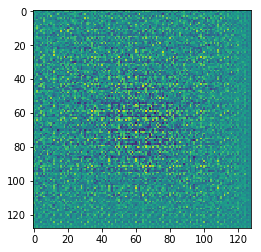

In [65]:
plt.show()

In [ ]:
##test
total_step = len(my_data_loader) ??
for epoch in range(num_epochs):
    for i, (images, captions) in enumerate(my_data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        print('Building the Generator')
        z = torch.randn(batch_size, latent_size).to(device)
        fake_image = self.generator(z, emb_caption)

        print('Building the Discriminator')
        disc_real_image, disc_real_image_logits,\
            disc_real_image_aux, disc_real_image_aux_logits= discriminator(real_images, emb_caption)
        disc_wrong_image, disc_wrong_image_logits, disc_wrong_image_aux, \
            disc_wrong_image_aux_logits  = discriminator(wrong_images, emb_caption)
        disc_fake_image, disc_fake_image_logits, disc_fake_image_aux, \
            disc_fake_image_aux_logits  = discriminator(fake_images, emb_caption)
        
        
        
        d_right_predictions = tf.equal(tf.argmax(disc_real_image_aux, 1),
                                       tf.argmax(t_real_classes, 1))
        d_right_accuracy = tf.reduce_mean(tf.cast(d_right_predictions,
                                                  tf.float32))

        d_wrong_predictions = tf.equal(tf.argmax(disc_wrong_image_aux, 1),
                                       tf.argmax(t_wrong_classes, 1))
        d_wrong_accuracy = tf.reduce_mean(tf.cast(d_wrong_predictions,
                                                  tf.float32))

        d_fake_predictions = tf.equal(tf.argmax(disc_fake_image_aux_logits, 1),
                                      tf.argmax(t_real_classes, 1))
        d_fake_accuracy = tf.reduce_mean(tf.cast(d_fake_predictions,
                                                 tf.float32))
        
        
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')